# Detection of Sarcopenia using Semantic Segmentation of CT scan data

## Major imports

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pydicom
import cv2
import matplotlib.image as mpimg
import os
import sys
import random
import warnings
import tensorflow as tf
import pandas as pd

from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.morphology import label
from sklearn.model_selection import train_test_split

## Read functions provided with dataset

In [24]:
def transform_to_hu(medical_image, image):
    hu_image = image * medical_image.RescaleSlope + medical_image.RescaleIntercept
    hu_image[hu_image < -1024] = -1024
    return hu_image

def window_image(image, window_center, window_width):
    window_image = image.copy()
    image_min = window_center - (window_width / 2)
    image_max = window_center + (window_width / 2)
    window_image[window_image < image_min] = image_min
    window_image[window_image > image_max] = image_max
    return window_image

def resize_normalize(image):
    image = np.array(image, dtype=np.float64)
    image -= np.min(image)
    image /= np.max(image)
    return image

def read_dicom(path, window_width, window_level):
    image_medical = pydicom.dcmread(path)
    image_data = image_medical.pixel_array

    image_hu = transform_to_hu(image_medical, image_data)
    image_window = window_image(image_hu.copy(), window_level, window_width)
    image_window_norm = resize_normalize(image_window)
#     image_window_norm = image_window

    image_window_norm = np.expand_dims(image_window_norm, axis=2)   # (512, 512, 1)
    image_ths = np.concatenate([image_window_norm, image_window_norm, image_window_norm], axis=2)   # (512, 512, 3)
    return image_ths

## Example CT scan

Raw image

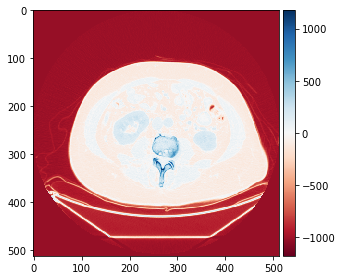

In [25]:
image_path = r"./train/DICOM/case025.dcm"
img_dcm = pydicom.dcmread(image_path)
imshow(img_dcm.pixel_array)
plt.show()

Converted to Grayscale with provided code

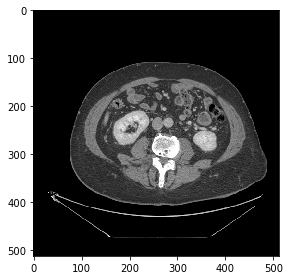

In [26]:
image_path = r"./train/DICOM/case025.dcm"
im = read_dicom(image_path, 500, 50)
imshow(im)
plt.show()

## Segmented label mask

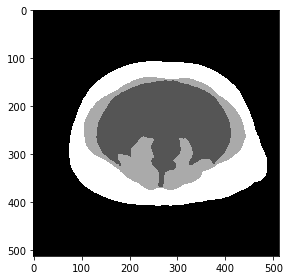

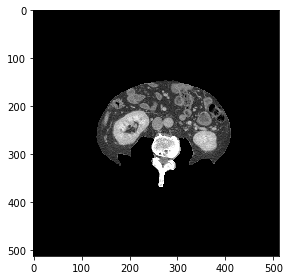

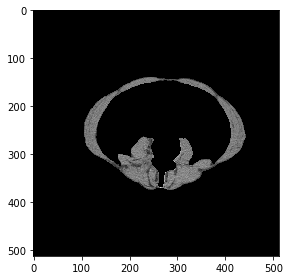

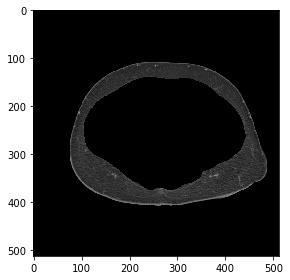

In [27]:
im = mpimg.imread(r"./train/Label/case025.png")
im = np.around(im, 8)

label = cv2.normalize(im, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

mask_1 = np.logical_and(label >= 0.1, label <= 0.4)
mask_2 = np.logical_and(label >= 0.5 ,label <= 0.9)
mask_3 = label >= 0.9

imshow(label)
plt.show()

im_ct = read_dicom(image_path, 500, 50)[:,:,0]

mask_1 = mask_1.astype(float)
organs = np.multiply(mask_1, im_ct)
imshow(organs)
plt.show()


mask_2 = mask_2.astype(float)
muscle = np.multiply(mask_2, im_ct)
imshow(muscle)
plt.show()


mask_3 = mask_3.astype(float)
fat = np.multiply(mask_3, im_ct)
imshow(fat)
plt.show()

## Keras imports

In [28]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping

## Input data constants

In [29]:
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 3
TRAIN_PATH_IMAGE = './train/DICOM/'
TRAIN_PATH_MASKS = './train/Label/'
TEST_PATH = './test/DICOM/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

## Input filenames

In [30]:
train_ids = [f for f in sorted(os.listdir(TRAIN_PATH_IMAGE)) if os.path.isfile(os.path.join(TRAIN_PATH_IMAGE, f))]
test_ids = [f for f in sorted(os.listdir(TEST_PATH)) if os.path.isfile(os.path.join(TEST_PATH, f))]

## Isolate segmentation masks

To index into individual tissue types

In [31]:
def get_mask_visceral(mask):
    mask_1 = np.logical_and(mask >= 0.1, mask <= 0.4)
    mask_1 = mask_1.astype(float)
    return mask_1

def get_mask_muscle(mask):
    mask_1 = np.logical_and(mask >= 0.5 ,mask <= 0.9)
    mask_1 = mask_1.astype(float)
    return mask_1

def get_mask_fat(mask):
    mask_1 = mask >= 0.9
    mask_1 = mask_1.astype(float)
    return mask_1

## Load and prepare data

In [32]:
# Get and resize train images and masks for region inside 
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
X_raw = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH), dtype=np.float32)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
PIXEL_SPACING = [0.0,0.0]
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH_IMAGE + id_
    img = read_dicom(path, 100, 50)
    X_train[n] = img
    img_dcm = pydicom.dcmread(path)
    X_raw[n] = img_dcm.pixel_array
    PIXEL_SPACING[0] += img_dcm.PixelSpacing[0]
    PIXEL_SPACING[1] += img_dcm.PixelSpacing[1]
    mask_path = TRAIN_PATH_MASKS + id_.replace('dcm', 'png')
    mask = mpimg.imread(mask_path)
    mask = np.around(mask, 8)
    mask = cv2.normalize(mask, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)


    m_v = get_mask_visceral(mask)
    m_m = get_mask_muscle(mask)
    m_f = get_mask_fat(mask)
    
    m_v = np.expand_dims(m_v, axis=-1)
    m_m = np.expand_dims(m_m, axis=-1)
    m_f = np.expand_dims(m_f, axis=-1)
    
    m_fin = np.concatenate([m_v, m_m, m_f], axis=-1)
    
    Y_train[n] = m_fin
PIXEL_SPACING[0] = PIXEL_SPACING[0]/len(train_ids)
PIXEL_SPACING[1] = PIXEL_SPACING[1]/len(train_ids)
# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
X_test_raw = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH), dtype=np.float32)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = read_dicom(path, 100, 50)
    img_dcm = pydicom.dcmread(path)
    X_test[n] = img
    X_test_raw[n] = img_dcm.pixel_array

Getting and resizing train images and masks ... 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 35.36it/s]

Getting and resizing test images ... 



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 72.89it/s]


## Split into Train and Validation

In [33]:
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=0)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (90, 512, 512, 3)
y_train:  (90, 512, 512, 3)
x_val:  (10, 512, 512, 3)
y_val:  (10, 512, 512, 3)


## Correlation metric - Dice cofficient (F1-score)

In [34]:
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice

## Model from Segmentation Models

See end of notebook for installation details

In [35]:
%env SM_FRAMEWORK=tf.keras
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

BACKBONE = 'efficientnetb7'
preprocess_input = get_preprocessing(BACKBONE)
model = Unet(BACKBONE, encoder_weights='imagenet', classes=3)
model.summary()

env: SM_FRAMEWORK=tf.keras
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, None, None, 6 1728        input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, None, None, 6 256         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, None, None, 6 0           stem_bn[0][0]                    
____________________________________________________________

## Compile model

In [36]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(lr=0.001), 
    loss=bce_jaccard_loss,
    metrics=[iou_score, dice_coef]
)

## Data generator with real time augmentation

In [37]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def get_augmented(
    X_train,
    Y_train,
    X_val=None,
    Y_val=None,
    batch_size=32,
    s=10,
    data_gen_args=dict(
        rotation_range=10.0,
        height_shift_range=0.02,
        shear_range=5,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode="constant",
    ),
):


    # Train data, provide the same seed and keyword arguments to the fit and flow methods
    X_datagen = ImageDataGenerator(**data_gen_args)
    Y_datagen = ImageDataGenerator(**data_gen_args)
    X_datagen.fit(X_train, augment=True, seed=s)
    Y_datagen.fit(Y_train, augment=True, seed=s)
    X_train_augmented = X_datagen.flow(
        X_train, batch_size=batch_size, shuffle=True, seed=s
    )
    Y_train_augmented = Y_datagen.flow(
        Y_train, batch_size=batch_size, shuffle=True, seed=s
    )

    train_generator = zip(X_train_augmented, Y_train_augmented)

    return train_generator

In [38]:
train_gen = get_augmented(
    x_train, y_train, batch_size=2,
    data_gen_args = dict(
        rotation_range=15.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=50,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))

## Callbacks for logging, early stopping, and learning rate

In [39]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger


model_filename = 'segm_model_norm.h5'

reduce_lr = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, mode='max',
                              patience=2, min_lr=0.0001)

callback_checkpoint = ModelCheckpoint(
    model_filename, 
    verbose=1, 
    monitor='val_dice_coef', 
    mode = 'max',
    save_best_only=True,
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_dice_coef', patience=5, mode='max'
)

hist_filename='log.csv'
history_logger=CSVLogger(hist_filename, separator=",", append=True)


## Training

### Load model if available

In [40]:
model_to_load = 'segm_model_norm.h5'
model.load_weights(model_to_load)

### Train for 500 epochs (with early stopping) Save model if improved metrics

In [50]:
history = model.fit(
    train_gen,
    steps_per_epoch=50,
    epochs=500,
    
    validation_data=(x_val, y_val),
    callbacks=[callback_checkpoint, reduce_lr, early_stop, history_logger]
)
model.save('trained_UNET_b7')


Epoch 1/500
50/50 [==============================] - ETA: 0s - loss: 0.2654 - iou_score: 0.7888 - dice_coef: 0.8918 
Epoch 00001: val_dice_coef improved from 0.64498 to 0.66237, saving model to segm_model_norm.h5
50/50 [==============================] - 1142s 23s/step - loss: 0.2654 - iou_score: 0.7888 - dice_coef: 0.8918 - val_loss: 0.6926 - val_iou_score: 0.5039 - val_dice_coef: 0.6624
Epoch 2/500
50/50 [==============================] - ETA: 0s - loss: 0.2384 - iou_score: 0.8092 - dice_coef: 0.9050 
Epoch 00002: val_dice_coef did not improve from 0.66237
50/50 [==============================] - 1105s 22s/step - loss: 0.2384 - iou_score: 0.8092 - dice_coef: 0.9050 - val_loss: 0.8250 - val_iou_score: 0.4578 - val_dice_coef: 0.5842
Epoch 3/500
50/50 [==============================] - ETA: 0s - loss: 0.2356 - iou_score: 0.8170 - dice_coef: 0.9085 
Epoch 00003: val_dice_coef did not improve from 0.66237
50/50 [==============================] - 1102s 22s/step - loss: 0.2356 - iou_score: 0

Epoch 23/500
50/50 [==============================] - ETA: 0s - loss: 0.1093 - iou_score: 0.9200 - dice_coef: 0.9635 
Epoch 00023: val_dice_coef did not improve from 0.97082
50/50 [==============================] - 1148s 23s/step - loss: 0.1093 - iou_score: 0.9200 - dice_coef: 0.9635 - val_loss: 0.0799 - val_iou_score: 0.9414 - val_dice_coef: 0.9706
Epoch 24/500
50/50 [==============================] - ETA: 0s - loss: 0.1064 - iou_score: 0.9227 - dice_coef: 0.9640 
Epoch 00024: val_dice_coef did not improve from 0.97082
50/50 [==============================] - 1138s 23s/step - loss: 0.1064 - iou_score: 0.9227 - dice_coef: 0.9640 - val_loss: 0.0824 - val_iou_score: 0.9395 - val_dice_coef: 0.9694
Epoch 25/500
50/50 [==============================] - ETA: 0s - loss: 0.1070 - iou_score: 0.9223 - dice_coef: 0.9643 
Epoch 00025: val_dice_coef did not improve from 0.97082
50/50 [==============================] - 1153s 23s/step - loss: 0.1070 - iou_score: 0.9223 - dice_coef: 0.9643 - val_loss:

KeyboardInterrupt: 

## Load the required state of the model and test

In [41]:
model.load_weights(model_to_load)

In [42]:
preds_train = np.zeros_like(X_train)

for i in tqdm(range(len(X_train)), total = len(X_train)):
    inp = X_train[i,:,:,:]
    out = model.predict(np.expand_dims(inp, axis=0))
    preds_train[i,:,:,:] = out

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:00<00:00,  1.20s/it]


In [43]:
preds_test = np.zeros_like(X_test)

for i in tqdm(range(len(X_test)), total = len(X_test)):
    inp = X_test[i,:,:,:]
    out = model.predict(np.expand_dims(inp, axis=0))
    preds_test[i,:,:,:] = out

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:58<00:00,  1.18s/it]


## Analysis of trained vs predicted

In [44]:
from statistics import mean,pstdev

In [45]:
area_list_gt = []
density_list_gt = []
area_list_pred = []
density_list_pred = []

ps = PIXEL_SPACING
for i in tqdm(range(len(X_train)), total = (len(X_train))):
    inp = cv2.cvtColor(X_train[i,:,:,:], cv2.COLOR_BGR2GRAY)
    img_raw = X_raw[i,:,:]
    
    label = Y_train[i,:,:,1]
    label = cv2.normalize(label, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
    label_pred = preds_train[i,:,:,1]
    
    HU_values = img_raw
    
    masked_CT = np.multiply(label, HU_values)
    masked_CT = list(masked_CT.flatten())
    muscle_hu=mean(masked_CT)

    
    masked_img = np.multiply(label, inp)
    list_img = list(masked_img[masked_img >= 0.3].flatten())
    muscle_area = len(list_img)*ps[0]*ps[1]*0.01
    
    area_list_gt.append(muscle_area)
    density_list_gt.append(muscle_hu)
    
    masked_CT_p = np.multiply(label_pred, HU_values)
    masked_CT_p = list(masked_CT_p.flatten())
    muscle_hu_p=mean(masked_CT_p)
    
    masked_img_p = np.multiply(label_pred, inp)
    list_img = list(masked_img_p[masked_img_p >= 0.3].flatten())
    muscle_area_p = len(list_img)*ps[0]*ps[1]*0.01
    
    area_list_pred.append(muscle_area_p)
    density_list_pred.append(muscle_hu_p)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:09<00:00,  1.44it/s]


## Plot of muscle area

### Red line shows threshold below which the patient can be diagnosed with sarcopenia

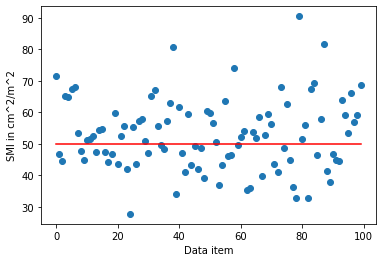

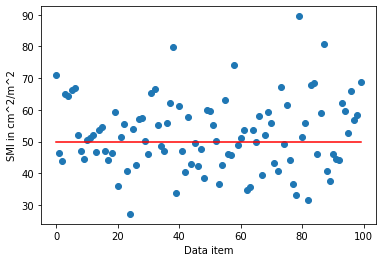

In [46]:
x_axis = range(len(train_ids))
avg_height_2 = 1.6*1.6
smi_list = [ area/avg_height_2 for area in area_list_gt]
smi_list_p = [ area/avg_height_2 for area in area_list_pred]

plt.figure()
plt.plot(x_axis, [50]*100, color = 'r')
plt.scatter(x_axis,smi_list)
plt.ylabel("SMI in cm^2/m^2")
plt.xlabel("Data item")
plt.show()

plt.figure()
plt.plot(x_axis, [50]*100, color = 'r')
plt.scatter(x_axis,smi_list_p)
plt.ylabel("SMI in cm^2/m^2")
plt.xlabel("Data item")
plt.show()

## Plot of muscle density

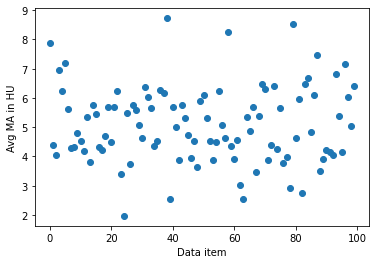

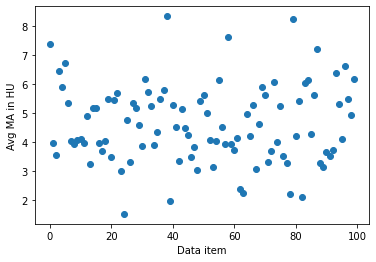

In [47]:
ma = plt.scatter(x_axis,density_list_gt)
plt.ylabel("Avg MA in HU")
plt.xlabel("Data item")
plt.show()

ma = plt.scatter(x_axis,density_list_pred)
plt.ylabel("Avg MA in HU")
plt.xlabel("Data item")
plt.show()

## Measure of correlation

### Bland-Altman plots to measure correlation of extracted values from predicted and ground truth segmentation

### Correlation of extracted muscle area

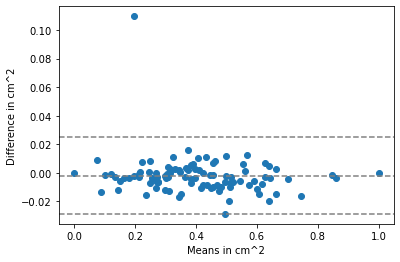

In [48]:
norm_smi = np.asarray(smi_list)
norm_smi = (norm_smi - np.min(norm_smi)) / (np.max(norm_smi) - np.min(norm_smi))
norm_smi_p = np.asarray(smi_list_p)
norm_smi_p = (norm_smi_p - np.min(norm_smi_p)) / (np.max(norm_smi_p) - np.min(norm_smi_p))

ba_mean = np.mean([norm_smi,norm_smi_p],axis = 0)
ba_diff = norm_smi - norm_smi_p

md = np.mean(ba_diff)
sd = np.std(ba_diff, axis=0)

plt.figure()
plt.scatter(ba_mean, ba_diff)
plt.axhline(md,           color='gray', linestyle='--')
plt.axhline(md + 1.96*sd, color='gray', linestyle='--')
plt.axhline(md - 1.96*sd, color='gray', linestyle='--')
plt.ylabel("Difference in cm^2")
plt.xlabel("Means in cm^2")
plt.show()

### Correlation of Muscle density

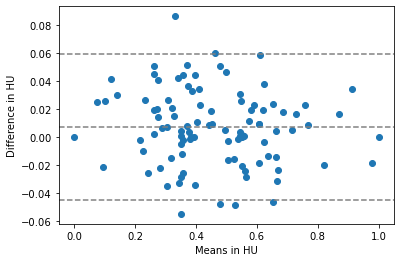

In [49]:
norm_ma = np.asarray(density_list_gt)
norm_ma = (norm_ma - np.min(norm_ma)) / (np.max(norm_ma) - np.min(norm_ma))
norm_ma_p = np.asarray(density_list_pred)
norm_ma_p = (norm_ma_p - np.min(norm_ma_p)) / (np.max(norm_ma_p) - np.min(norm_ma_p))

ba_mean = np.mean([norm_ma,norm_ma_p],axis = 0)
ba_diff = norm_ma - norm_ma_p

md = np.mean(ba_diff)
sd = np.std(ba_diff, axis=0)

plt.figure()
plt.scatter(ba_mean, ba_diff)
plt.axhline(md,           color='gray', linestyle='--')
plt.axhline(md + 1.96*sd, color='gray', linestyle='--')
plt.axhline(md - 1.96*sd, color='gray', linestyle='--')
plt.ylabel("Difference in HU")
plt.xlabel("Means in HU")
plt.show()

## Targeting good points and outliers

In [28]:
print(np.where(ba_diff< (md + 0.001)))
print(np.where(ba_diff> (md + 1.96*sd)))

(array([ 1,  2,  4,  6,  7,  8, 10, 11, 12, 15, 16, 19, 21, 23, 24, 26, 27,
       28, 31, 32, 33, 34, 35, 37, 38, 40, 46, 51, 52, 54, 55, 59, 60, 61,
       63, 64, 66, 67, 73, 74, 75, 76, 79, 80, 83, 87, 88, 92, 93, 94, 95,
       98, 99], dtype=int64),)
(array([20, 44], dtype=int64),)


## Highly correlated segmentation

In [29]:
    inp = cv2.cvtColor(X_train[0,:,:,:], cv2.COLOR_BGR2GRAY)
   
    label = Y_train[0,:,:,1]
    label = cv2.normalize(label, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
    label_pred = preds_train[0,:,:,1]


    
    masked_img = np.multiply(label, inp)
    list_img = list(masked_img[masked_img >= 0.3].flatten())
    muscle_area = len(list_img)*ps[0]*ps[1]*0.01

    
    masked_img_p = np.multiply(label_pred, inp)
    list_img = list(masked_img_p[masked_img_p >= 0.3].flatten())
    muscle_area_p = len(list_img)*ps[0]*ps[1]*0.01

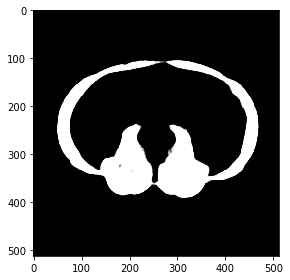

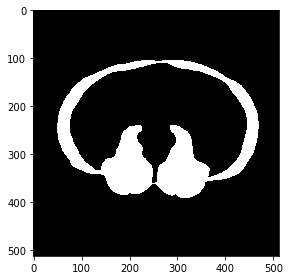

In [30]:
imshow(label_pred)
plt.show()

imshow(label)
plt.show()

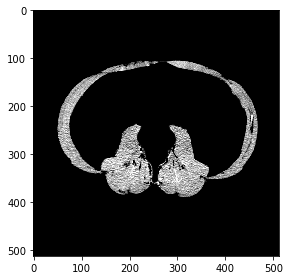

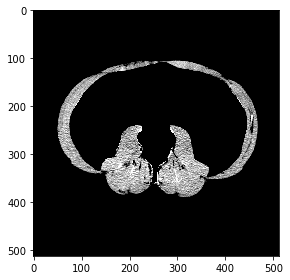

In [31]:
imshow(masked_img_p)
plt.show()

imshow(masked_img)
plt.show()

## Low correlation - suboptimal segmentation

In [32]:
    inp = cv2.cvtColor(X_train[20,:,:,:], cv2.COLOR_BGR2GRAY)

    
    label = Y_train[20,:,:,1]
    label = cv2.normalize(label, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
    label_pred = preds_train[20,:,:,1]
    
    
    masked_img = np.multiply(label, inp)
    list_img = list(masked_img[masked_img >= 0.3].flatten())
    muscle_area = len(list_img)*ps[0]*ps[1]*0.01

    masked_img_p = np.multiply(label_pred, inp)
    list_img = list(masked_img_p[masked_img_p >= 0.3].flatten())
    muscle_area_p = len(list_img)*ps[0]*ps[1]*0.01

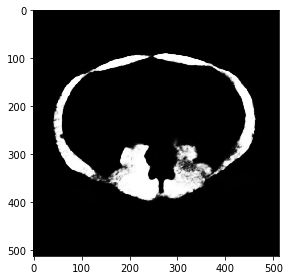

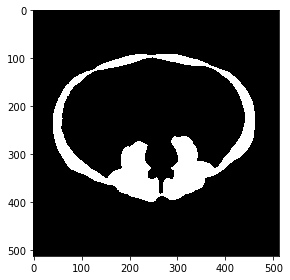

In [33]:
imshow(label_pred)
plt.show()

imshow(label)
plt.show()

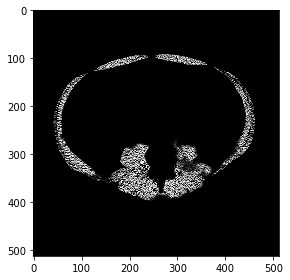

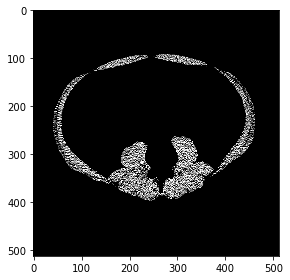

In [34]:
imshow(masked_img_p)
plt.show()

imshow(masked_img)
plt.show()

## Analysis of Test data

No ground truth mask available

In [51]:
area_list_pred = []
density_list_pred = []

ps = PIXEL_SPACING
for i in tqdm(range(len(X_test)), total = (len(X_test))):
    inp = cv2.cvtColor(X_test[i,:,:,:], cv2.COLOR_BGR2GRAY)
    img_raw = X_test_raw[i,:,:]
       
    label_pred = preds_test[i,:,:,1]
    
    HU_values = img_raw
    
 
    masked_CT_p = np.multiply(label_pred, HU_values)
    masked_CT_p = list(masked_CT_p.flatten())
    muscle_hu_p=mean(masked_CT_p)
    
    masked_img_p = np.multiply(label_pred, inp)
    list_img = list(masked_img_p[masked_img_p >= 0.3].flatten())
    muscle_area_p = len(list_img)*ps[0]*ps[1]*0.01
    
    area_list_pred.append(muscle_area_p)
    density_list_pred.append(muscle_hu_p)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.94it/s]


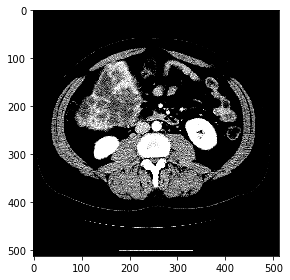

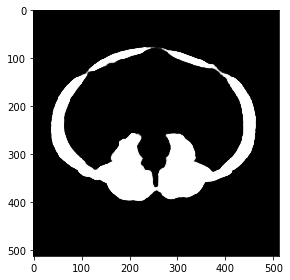

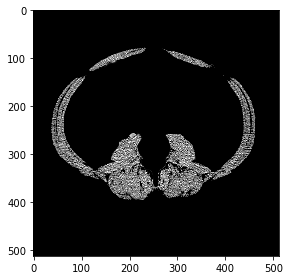

In [52]:
imshow(X_test[1,:,:])
plt.show()

imshow(preds_test[1,:,:,1])
plt.show()

masked = np.multiply(preds_test[1,:,:,1], X_test[1,:,:,1])
imshow(masked)
plt.show()

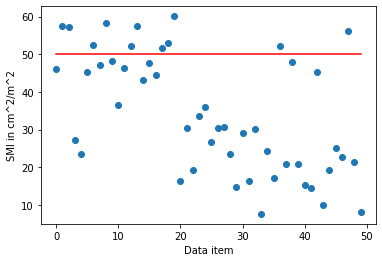

In [53]:
x_axis = range(len(test_ids))
avg_height_2 = 1.6*1.6
smi_list_p = [ area/avg_height_2 for area in area_list_pred]

plt.figure()
plt.plot(x_axis, [50]*50, color = 'r')
plt.scatter(x_axis,smi_list_p)
plt.ylabel("SMI in cm^2/m^2")
plt.xlabel("Data item")
plt.show()

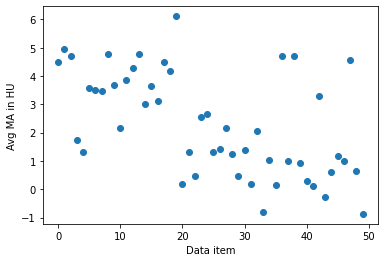

In [54]:
ma = plt.scatter(x_axis,density_list_pred)
plt.ylabel("Avg MA in HU")
plt.xlabel("Data item")
plt.show()

## Analysis of training process

In [4]:
hist = pd.read_csv(hist_filename)
print(hist.keys())

Index(['dice_coef', 'iou_score', 'loss', 'lr', 'val_dice_coef',
       'val_iou_score', 'val_loss'],
      dtype='object')


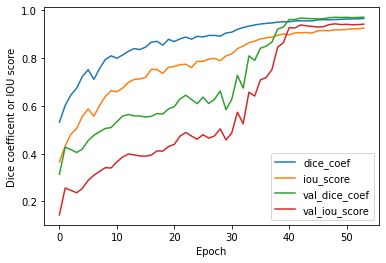

In [15]:
x = range(len(hist['dice_coef']))

plt.figure()
y = hist['dice_coef']
plt.plot(x,y, label = 'dice_coef')
y = hist['iou_score']
plt.plot(x,y, label = 'iou_score')
y = hist['val_dice_coef']
plt.plot(x,y, label = 'val_dice_coef')
y = hist['val_iou_score']
plt.plot(x,y, label = 'val_iou_score')
plt.ylabel("Dice coefficent or IOU score")
plt.xlabel("Epoch")
plt.legend()
plt.show()

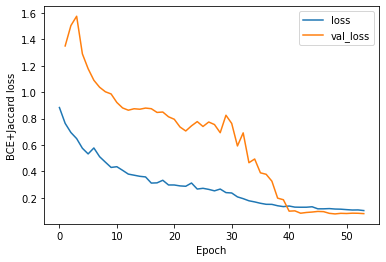

In [16]:
x = range(len(hist['loss']))

plt.figure()
y = hist['loss']
plt.plot(x,y, label = 'loss')
y = hist['val_loss']
plt.plot(x,y, label = 'val_loss')
plt.ylabel("BCE+Jaccard loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

Package of Segmentation Models [link](https://segmentation-models.readthedocs.io/en/latest/api.html#linknet)

In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models